In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel as C,
    ExpSineSquared,
    DotProduct,
    WhiteKernel
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score

In [2]:
train = pd.read_csv('./processed_data/train.csv')
train['tip_amount'] = train['tip_amount'].fillna(0)
train['tpep_pickup_datetime'] = pd.to_datetime(train['tpep_pickup_datetime'])
train = train.set_index('tpep_pickup_datetime')

train['interval'] = range(1, len(train) + 1)
train['interval'] = train['interval'] % 48 # Get to hour interval (use the time actually, why modulo lol)
train['tpep_pickup_datetime'] = train.index
train['time_index'] = range(1, len(train) + 1)

train = train[:800]
train.head()

,passenger_count,trip_distance,DOLocationID,fare_amount,total_amount,tip_amount,pickup_count,weekday,is_holiday,interval,tpep_pickup_datetime,time_index
tpep_pickup_datetime,,,,,,,,,,,,
2022-01-24 00:00:00,13.0,49.14,1583,173.00,237.35,1.615,12,0,False,1,2022-01-24 00:00:00,1
2022-01-24 00:30:00,9.0,51.99,1524,174.43,245.92,2.770,9,0,False,2,2022-01-24 00:30:00,2
2022-01-24 01:00:00,12.0,37.72,1242,137.50,209.51,2.110,12,0,False,3,2022-01-24 01:00:00,3
2022-01-24 01:30:00,7.0,11.99,785,50.50,86.39,2.010,6,0,False,4,2022-01-24 01:30:00,4
2022-01-24 02:00:00,7.0,15.40,998,64.50,94.95,0.000,6,0,False,5,2022-01-24 02:00:00,5


In [3]:
test = pd.read_csv('./processed_data/test.csv')
test['tip_amount'] = test['tip_amount'].fillna(0)
test['tpep_pickup_datetime'] = pd.to_datetime(test['tpep_pickup_datetime'])
test = test.set_index('tpep_pickup_datetime')

test['interval'] = range(1, len(test) + 1)
test['interval'] = test['interval'] % 48 # Get to 30 minute interval
test['tpep_pickup_datetime'] = test.index
test['time_index'] = range(1, len(test) + 1)
test = test[:800]
test.head()

,passenger_count,trip_distance,DOLocationID,fare_amount,total_amount,tip_amount,pickup_count,weekday,is_holiday,interval,tpep_pickup_datetime,time_index
tpep_pickup_datetime,,,,,,,,,,,,
2024-01-22 00:00:00,13.0,24.75,1545,137.1,201.46,0.00,10,0,False,1,2024-01-22 00:00:00,1
2024-01-22 00:30:00,17.0,22.92,1645,122.1,193.90,0.00,14,0,False,2,2024-01-22 00:30:00,2
2024-01-22 01:00:00,15.0,35.45,2733,194.8,305.46,2.58,15,0,False,3,2024-01-22 01:00:00,3
2024-01-22 01:30:00,9.0,19.71,1280,104.0,160.07,1.00,9,0,False,4,2024-01-22 01:30:00,4
2024-01-22 02:00:00,8.0,14.74,617,78.9,114.34,0.00,6,0,False,5,2024-01-22 02:00:00,5


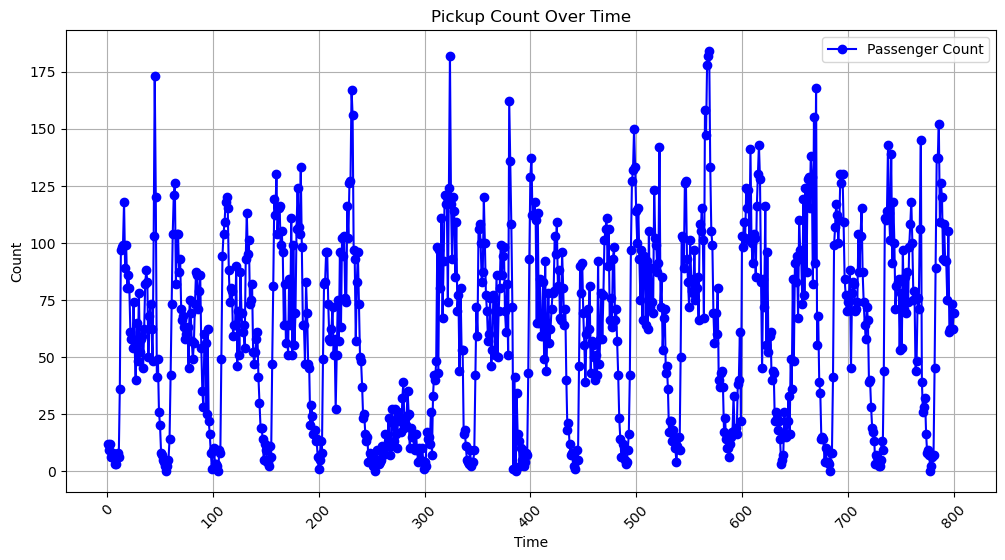

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(train['time_index'], train['pickup_count'], marker='o', label='Passenger Count', color='blue')
plt.title('Pickup Count Over Time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 800 entries, 2022-01-24 00:00:00 to 2022-02-09 14:30:00
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   passenger_count       800 non-null    float64       
 1   trip_distance         800 non-null    float64       
 2   DOLocationID          800 non-null    int64         
 3   fare_amount           800 non-null    float64       
 4   total_amount          800 non-null    float64       
 5   tip_amount            800 non-null    float64       
 6   pickup_count          800 non-null    int64         
 7   weekday               800 non-null    int64         
 8   is_holiday            800 non-null    bool          
 9   interval              800 non-null    int64         
 10  tpep_pickup_datetime  800 non-null    datetime64[ns]
 11  time_index            800 non-null    int64         
dtypes: bool(1), datetime64[ns](1), float64(5)

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 800 entries, 2024-01-22 00:00:00 to 2024-02-07 15:00:00
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   passenger_count       800 non-null    float64       
 1   trip_distance         800 non-null    float64       
 2   DOLocationID          800 non-null    int64         
 3   fare_amount           800 non-null    float64       
 4   total_amount          800 non-null    float64       
 5   tip_amount            800 non-null    float64       
 6   pickup_count          800 non-null    int64         
 7   weekday               800 non-null    int64         
 8   is_holiday            800 non-null    bool          
 9   interval              800 non-null    int64         
 10  tpep_pickup_datetime  800 non-null    datetime64[ns]
 11  time_index            800 non-null    int64         
dtypes: bool(1), datetime64[ns](1), float64(5)

In [7]:
# Features (X) - All columns except 'pickup_count'
X_train = train[['interval', 'weekday']].values
X_test = test[['interval', 'weekday']].values

# Target (y) - 'pickup_count'
# Subtract the mean function (use training data)
mean_func = train['pickup_count'].mean()
y_train = train['pickup_count'].values - mean_func
y_test = test['pickup_count'].values - mean_func

# Scale features if necessary (important for GP models to avoid dominance of larger scale features)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#print(X_scaled)

In [8]:
X_train

array([[-1.61399892, -1.31426384],
       [-1.54136171, -1.31426384],
       [-1.46872449, -1.31426384],
       ...,
       [ 0.49248032, -0.32423458],
       [ 0.56511753, -0.32423458],
       [ 0.63775475, -0.32423458]])

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((800, 2), (800,), (800, 2), (800,))

In [10]:
# Define the GP kernel
# - RBF for smooth trends
# - ExpSineSquared for periodicity
kernel = (
    C(10.0, (1e-3, 1e3))  # Constant term to scale the entire kernel
    * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))  # Squared exponential

    + C(50.0, (1e-3, 1e3))  # Constant term for cosine scaling
    * ExpSineSquared(length_scale=1.0, periodicity=336, periodicity_bounds=(1e-2, 1e2), length_scale_bounds=(1e-2, 1e2))  # Cosine
## These two above work

    + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-05, 100000.0))
)

# Instantiate and fit the Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, alpha=1e-5)
gp.fit(X_train, y_train)
print("Fit Complete")
print("Learned Kernel:", gp.kernel_)

# Make predictions (add mean back)
y_pred, sigma = gp.predict(X_test, return_std=True)

Fit Complete
Learned Kernel: 31.2**2 * RBF(length_scale=0.369) + 5.2**2 * ExpSineSquared(length_scale=2.6, periodicity=0.375) + WhiteKernel(noise_level=504)


Root Mean Squared Error: 32.109
R^2 Score: 0.511


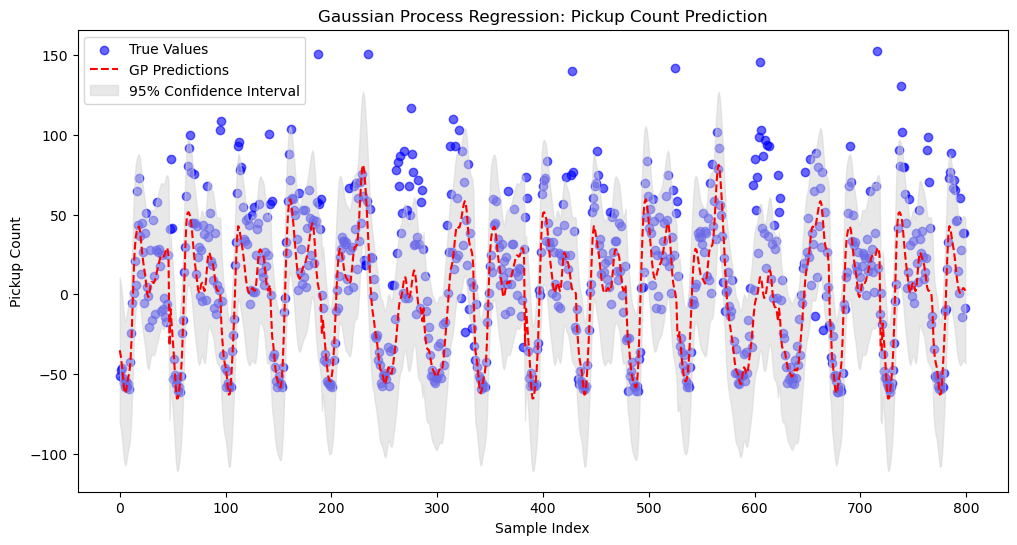

In [11]:
# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test)), y_test, label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred)), y_pred, label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred)),
    y_pred - 1.96 * sigma,
    y_pred + 1.96 * sigma,
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction")
plt.legend()
plt.show()


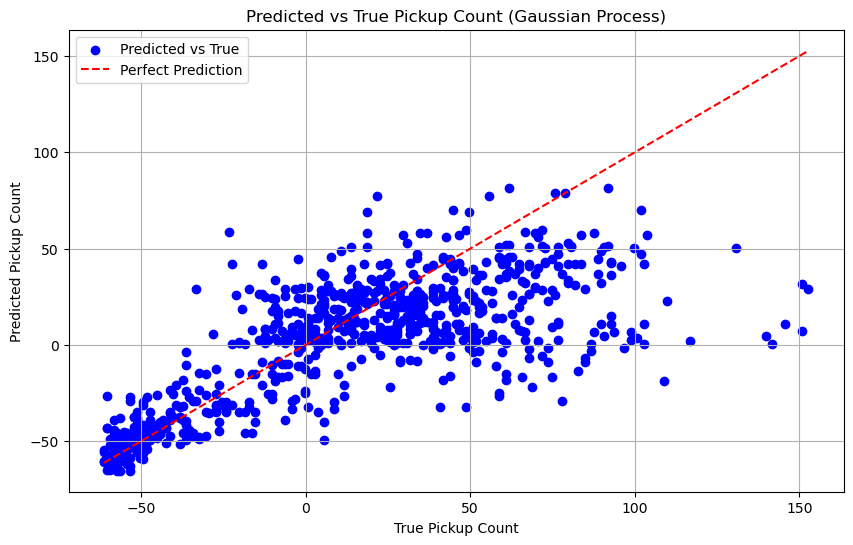

In [12]:
# Prediction vs True Values plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs True')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('True Pickup Count')
plt.ylabel('Predicted Pickup Count')
plt.title('Predicted vs True Pickup Count (Gaussian Process)')
plt.legend()
plt.grid(True)
plt.show()

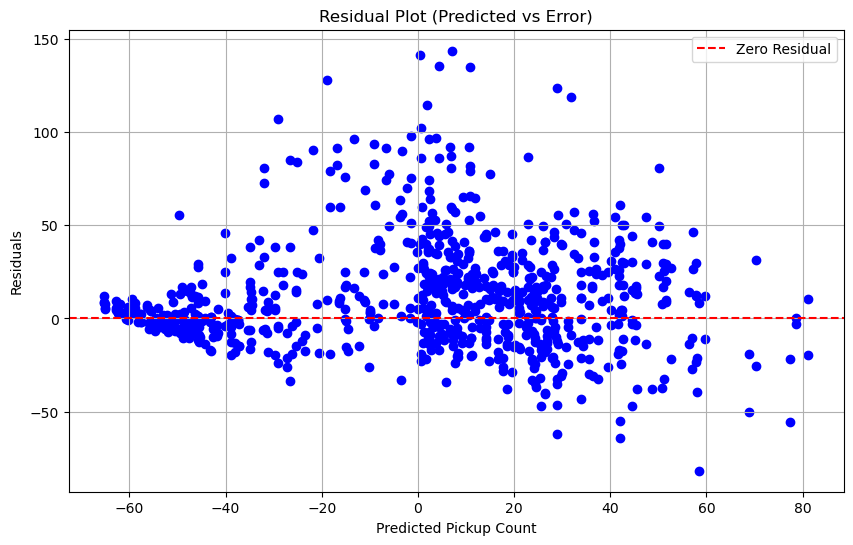

In [13]:
# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

# R²
r2 = r2_score(y_test, y_pred)
print("R²:", r2)


RMSE: 32.109011691919754
R²: 0.5110174094154972


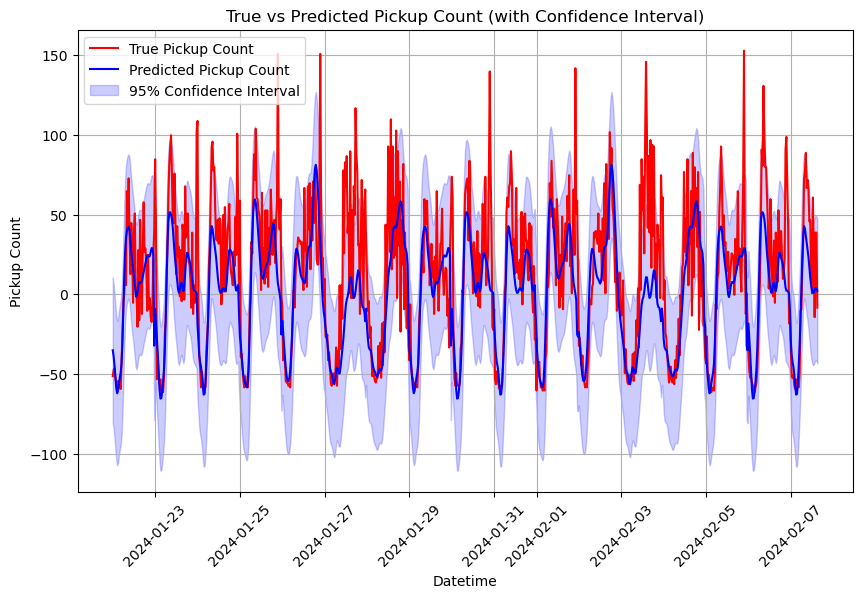

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(test['tpep_pickup_datetime'], y_test, label='True Pickup Count', color='red')
plt.plot(test['tpep_pickup_datetime'], y_pred, label='Predicted Pickup Count', color='blue')
plt.fill_between(test['tpep_pickup_datetime'], y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Datetime')
plt.ylabel('Pickup Count')
plt.title('True vs Predicted Pickup Count (with Confidence Interval)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()